In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm, tqdm_pandas

In [2]:
# Load in data
column_names = ['ID', 'Title', 'From', 'To', 'House', 'Term', 'Session', 'Meeting',
       'Sitting', 'Agenda', 'Subcorpus', 'Speaker_role', 'Speaker_type',
       'Speaker_party', 'Speaker_party_name', 'Party_status', 'Speaker_name',
       'Speaker_gender', 'Speaker_birth', "Text"]
ParlaMint = pd.read_csv("data/parlamint.csv", index_col=False, usecols = column_names)

### Size of dataset

In [3]:
MB_size = os.path.getsize("data/parlamint.csv") / 1024 / 1024 # Convert from byte to MB
print(f"The dataset is {MB_size:0.2f} MB.")
print(f"The dataset consists of {ParlaMint.shape[0]} datapoints each with a feature length of {ParlaMint.shape[1]}.")


The dataset is 676.02 MB.
The dataset consists of 552103 datapoints each with a feature length of 20.


In [4]:
ParlaMint.count()

ID                    552103
Title                 552103
From                  552103
To                    552103
House                 552103
Term                  552103
Session                    0
Meeting                    0
Sitting                    0
Agenda                     0
Subcorpus             552103
Speaker_role          552103
Speaker_type          552103
Speaker_party         550489
Speaker_party_name    551961
Party_status          548885
Speaker_name          552103
Speaker_gender        552103
Speaker_birth         552103
Text                  552103
dtype: int64

As seen above they are a few nan values (could remove those?)
Should also remove "Session", "Meeting", "Sitting", "Agenda" since all values are nans.

In [5]:
ParlaMint = ParlaMint.drop(["Session", "Meeting", "Sitting", "Agenda"], axis = 1)
ParlaMint.shape[1]

16

### Network analysis

To successfully alter the dataset into a network structure some relatively extensive data transformation will be necessary. One possible approach is to try and identify most common topics in the corpus and then try to create links between parties/members and what topic they addresses.

#### Wordcloud (Term frequency)
Initially, a WordCloud based on counts from all of the talks.

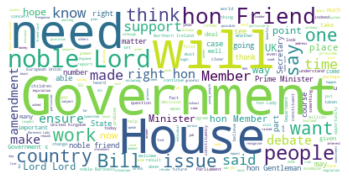

In [11]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(' '.join(ParlaMint['Text'].lower()))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

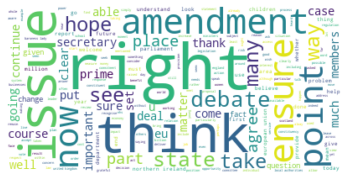

In [14]:
#Trying to update set off stopwords, with non-informative words above
stopwords.update(["government", "house", "will", "need",
                  "lord", "people", "country", "minister",
                 "member", "said", "noble", "uk", "united kingdom", "gentleman", "may",
                 "hon", "friend", "lords", "bill", "know", "one", "time", "work",
                 "say", "want", "made", "make", "support", "number"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(' '.join(ParlaMint['Text']).lower())
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

As the above wordcloud demonstrates, then there is still issues with the most frequent words being non-informative about the important issues addressed within the parliament. A few interesting terms might indicate common topics/issues e.g "eu".

In [22]:
import nltk
from tqdm import tqdm
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#### Topic modelling (LDA)
Given that the above approach did not work out as intended, the next attempt will be to try and use LDA, to provide insights into the pressing issues within the british parliament. First lets preprocess the data by removing stop words and conduct stemming.

In [44]:
#Importing two different normalization methods
porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()

def preprocess(text):
    #Common english stop words
    stop_words = set(stopwords.words('english'))
    stop_words.update(["government", "house", "will", "need",
                "lord", "people", "country", "minister",
                "member", "said", "noble", "uk", "united kingdom", "gentleman", "may",
                "hon", "friend", "lords", "bill", "know", "one", "time", "work",
                "say", "want", "made", "make", "support", "number", "baro", "constitution",
                "time", "act", "requirement", "provide",
                "would", "amendment", "committee", "important", "ensure", "member", "debate",
                "vote", "think", "go", "also", "right", "change", "point"])
    #Tokenize using nltk
    word_tokens = word_tokenize(text.lower())
    #removing none letter characters and stop words
    filtered_sentence = [w for w in word_tokens if w not in stop_words and w.isalpha()]
    #Conduct stemming
    processed_text = [porter.stem(t) for t in filtered_sentence]
    return processed_text
    
ParlaMint['tokens'] = [preprocess(x) for x in tqdm(ParlaMint['Text'])]


  0%|▍                                                                                                                                                                                              | 1433/552103 [00:05<33:23, 274.86it/s]


  1%|▉                                                                                                                                                                                              | 2839/552103 [00:10<21:21, 428.66it/s]


  1%|█▍                                                                                                                                                                                             | 4231/552103 [00:15<18:30, 493.54it/s]


  1%|█▉                                                                                                                                                                                             | 5602/552103 [00:20<22:48, 399.32it/s]


  1%|██▍                                                                                                                                                                                            | 7226/552103 [00:25<33:09, 273.87it/s]


  2%|███                                                                                                                                                                                            | 8722/552103 [00:31<41:17, 219.30it/s]


  2%|███▌                                                                                                                                                                                          | 10266/552103 [00:36<40:06, 225.15it/s]


  2%|████                                                                                                                                                                                          | 11938/552103 [00:41<22:50, 394.25it/s]


  2%|████▋                                                                                                                                                                                         | 13499/552103 [00:46<24:28, 366.78it/s]


  3%|█████▏                                                                                                                                                                                        | 14959/552103 [00:51<49:37, 180.40it/s]


  3%|█████▋                                                                                                                                                                                        | 16437/552103 [00:56<29:59, 297.65it/s]


  3%|██████▏                                                                                                                                                                                       | 18098/552103 [01:01<33:00, 269.57it/s]


  4%|██████▋                                                                                                                                                                                       | 19590/552103 [01:07<24:31, 361.89it/s]


  4%|███████▎                                                                                                                                                                                      | 21072/552103 [01:12<37:35, 235.43it/s]


  4%|███████▊                                                                                                                                                                                      | 22586/552103 [01:18<36:46, 240.03it/s]


  4%|████████▎                                                                                                                                                                                     | 24127/552103 [01:23<30:24, 289.42it/s]


  5%|████████▊                                                                                                                                                                                     | 25438/552103 [01:29<52:07, 168.42it/s]


  5%|█████████▎                                                                                                                                                                                    | 27116/552103 [01:34<22:37, 386.62it/s]


  5%|█████████▌                                                                                                                                                                                   | 28076/552103 [01:40<1:50:09, 79.28it/s]


  5%|██████████▏                                                                                                                                                                                   | 29430/552103 [01:47<58:34, 148.73it/s]


  6%|██████████▋                                                                                                                                                                                   | 31237/552103 [01:53<25:22, 342.08it/s]


  6%|███████████▍                                                                                                                                                                                  | 33093/552103 [01:59<20:05, 430.48it/s]


  6%|████████████                                                                                                                                                                                  | 34899/552103 [02:04<19:02, 452.64it/s]


  7%|████████████▌                                                                                                                                                                                 | 36566/552103 [02:10<25:45, 333.50it/s]


  7%|█████████████                                                                                                                                                                                 | 38136/552103 [02:15<39:06, 219.00it/s]


  7%|█████████████▋                                                                                                                                                                                | 39688/552103 [02:20<22:20, 382.16it/s]


  8%|██████████████▎                                                                                                                                                                               | 41523/552103 [02:26<24:09, 352.13it/s]


  8%|██████████████▉                                                                                                                                                                               | 43383/552103 [02:31<25:01, 338.82it/s]


  8%|███████████████▍                                                                                                                                                                              | 44960/552103 [02:37<24:28, 345.28it/s]


  8%|███████████████▊                                                                                                                                                                            | 46525/552103 [02:42<1:16:01, 110.84it/s]


  9%|████████████████▌                                                                                                                                                                             | 48308/552103 [02:47<31:44, 264.49it/s]


  9%|█████████████████▏                                                                                                                                                                            | 49934/552103 [02:53<34:34, 242.06it/s]


  9%|█████████████████▋                                                                                                                                                                            | 51455/552103 [02:58<28:40, 291.07it/s]


 10%|██████████████████                                                                                                                                                                          | 52893/552103 [03:04<1:01:35, 135.07it/s]


 10%|██████████████████▊                                                                                                                                                                           | 54566/552103 [03:10<47:35, 174.24it/s]


 10%|███████████████████▎                                                                                                                                                                          | 56153/552103 [03:15<23:54, 345.62it/s]


 10%|███████████████████▊                                                                                                                                                                          | 57704/552103 [03:20<26:35, 309.93it/s]


 11%|████████████████████▎                                                                                                                                                                         | 59096/552103 [03:25<44:38, 184.05it/s]


 11%|████████████████████▊                                                                                                                                                                         | 60601/552103 [03:30<28:23, 288.60it/s]


 11%|█████████████████████▍                                                                                                                                                                        | 62362/552103 [03:35<35:16, 231.37it/s]


 12%|██████████████████████                                                                                                                                                                        | 64096/552103 [03:40<21:35, 376.83it/s]


 12%|██████████████████████▌                                                                                                                                                                       | 65678/552103 [03:44<15:34, 520.73it/s]


 12%|███████████████████████▏                                                                                                                                                                      | 67521/552103 [03:49<18:00, 448.32it/s]


 13%|███████████████████████▊                                                                                                                                                                      | 69273/552103 [03:54<20:16, 396.93it/s]


 13%|████████████████████████▍                                                                                                                                                                     | 70842/552103 [04:00<31:23, 255.51it/s]


 13%|████████████████████████▉                                                                                                                                                                     | 72458/552103 [04:05<21:30, 371.81it/s]


 13%|█████████████████████████▌                                                                                                                                                                    | 74164/552103 [04:10<27:34, 288.93it/s]


 14%|██████████████████████████                                                                                                                                                                    | 75607/552103 [04:16<45:06, 176.05it/s]


 14%|██████████████████████████▌                                                                                                                                                                   | 77056/552103 [04:21<23:19, 339.42it/s]


 14%|███████████████████████████                                                                                                                                                                   | 78647/552103 [04:26<58:08, 135.73it/s]


 15%|███████████████████████████▋                                                                                                                                                                  | 80343/552103 [04:31<20:39, 380.49it/s]


 15%|████████████████████████████▏                                                                                                                                                                 | 81843/552103 [04:36<31:22, 249.78it/s]


 15%|████████████████████████████▋                                                                                                                                                                 | 83536/552103 [04:41<22:12, 351.67it/s]


 15%|█████████████████████████████▎                                                                                                                                                                | 85141/552103 [04:47<20:28, 380.17it/s]


 16%|█████████████████████████████▊                                                                                                                                                                | 86544/552103 [04:52<36:44, 211.19it/s]


 16%|██████████████████████████████▎                                                                                                                                                               | 87988/552103 [04:57<30:03, 257.28it/s]


 16%|██████████████████████████████▊                                                                                                                                                               | 89511/552103 [05:03<40:01, 192.63it/s]


 16%|███████████████████████████████▎                                                                                                                                                              | 91093/552103 [05:08<27:23, 280.57it/s]


 17%|███████████████████████████████▋                                                                                                                                                              | 92235/552103 [05:14<24:40, 310.57it/s]


 17%|████████████████████████████████▎                                                                                                                                                             | 93997/552103 [05:18<19:10, 398.30it/s]


 17%|████████████████████████████████▊                                                                                                                                                             | 95375/552103 [05:23<17:29, 435.23it/s]


 18%|█████████████████████████████████▎                                                                                                                                                            | 96908/552103 [05:28<16:10, 468.90it/s]


 18%|█████████████████████████████████▉                                                                                                                                                            | 98595/552103 [05:33<17:04, 442.71it/s]


 18%|██████████████████████████████████▎                                                                                                                                                          | 100296/552103 [05:38<28:43, 262.14it/s]


 18%|██████████████████████████████████▊                                                                                                                                                          | 101872/552103 [05:42<17:08, 437.61it/s]


 19%|███████████████████████████████████▍                                                                                                                                                         | 103387/552103 [05:48<24:17, 307.94it/s]


 19%|███████████████████████████████████▉                                                                                                                                                         | 104930/552103 [05:53<24:55, 299.06it/s]


 19%|████████████████████████████████████▍                                                                                                                                                        | 106582/552103 [05:58<27:07, 273.68it/s]


 20%|████████████████████████████████████▉                                                                                                                                                        | 108011/552103 [06:02<23:47, 311.18it/s]


 20%|█████████████████████████████████████▌                                                                                                                                                       | 109549/552103 [06:07<16:03, 459.54it/s]


 20%|██████████████████████████████████████                                                                                                                                                       | 111112/552103 [06:12<15:06, 486.46it/s]


 20%|██████████████████████████████████████▌                                                                                                                                                      | 112485/552103 [06:17<16:23, 446.99it/s]


 21%|███████████████████████████████████████                                                                                                                                                      | 114045/552103 [06:22<33:28, 218.12it/s]


 21%|███████████████████████████████████████▌                                                                                                                                                     | 115533/552103 [06:27<23:08, 314.33it/s]


 21%|████████████████████████████████████████                                                                                                                                                     | 117036/552103 [06:32<25:15, 287.07it/s]


 21%|████████████████████████████████████████▌                                                                                                                                                    | 118504/552103 [06:38<17:32, 411.86it/s]


 22%|█████████████████████████████████████████                                                                                                                                                    | 120114/552103 [06:43<33:03, 217.76it/s]


 22%|█████████████████████████████████████████▌                                                                                                                                                   | 121559/552103 [06:48<26:38, 269.31it/s]


 22%|██████████████████████████████████████████▏                                                                                                                                                  | 123297/552103 [06:53<32:40, 218.76it/s]


 23%|██████████████████████████████████████████▋                                                                                                                                                  | 124580/552103 [06:59<47:32, 149.86it/s]


 23%|███████████████████████████████████████████▏                                                                                                                                                 | 126072/552103 [07:06<17:31, 405.28it/s]


 23%|███████████████████████████████████████████▋                                                                                                                                                 | 127617/552103 [07:11<21:10, 334.14it/s]


 23%|████████████████████████████████████████████▏                                                                                                                                                | 129165/552103 [07:17<28:46, 244.94it/s]


 24%|████████████████████████████████████████████▊                                                                                                                                                | 130726/552103 [07:23<20:28, 342.90it/s]


 24%|█████████████████████████████████████████████▎                                                                                                                                               | 132449/552103 [07:29<28:47, 242.98it/s]


 24%|█████████████████████████████████████████████▉                                                                                                                                               | 134077/552103 [07:35<37:05, 187.86it/s]


 25%|██████████████████████████████████████████████▍                                                                                                                                              | 135517/552103 [07:41<37:59, 182.76it/s]


 25%|██████████████████████████████████████████████▉                                                                                                                                              | 137074/552103 [07:46<24:56, 277.35it/s]


 25%|███████████████████████████████████████████████▍                                                                                                                                             | 138704/552103 [07:52<30:08, 228.55it/s]


 25%|███████████████████████████████████████████████▉                                                                                                                                             | 140204/552103 [07:58<24:22, 281.59it/s]


 26%|████████████████████████████████████████████████▌                                                                                                                                            | 141828/552103 [08:03<25:06, 272.33it/s]


 26%|█████████████████████████████████████████████████                                                                                                                                            | 143458/552103 [08:09<25:34, 266.37it/s]


 26%|█████████████████████████████████████████████████▋                                                                                                                                           | 145229/552103 [08:14<18:04, 375.28it/s]


 27%|██████████████████████████████████████████████████▎                                                                                                                                          | 146898/552103 [08:20<21:52, 308.83it/s]


 27%|██████████████████████████████████████████████████▊                                                                                                                                          | 148578/552103 [08:26<19:24, 346.43it/s]


 27%|███████████████████████████████████████████████████▍                                                                                                                                         | 150236/552103 [08:31<25:12, 265.71it/s]


 28%|████████████████████████████████████████████████████                                                                                                                                         | 152052/552103 [08:36<17:00, 392.08it/s]


 28%|████████████████████████████████████████████████████▌                                                                                                                                        | 153615/552103 [08:42<21:05, 314.80it/s]


 28%|█████████████████████████████████████████████████████▏                                                                                                                                       | 155227/552103 [08:47<15:15, 433.47it/s]


 28%|█████████████████████████████████████████████████████▋                                                                                                                                       | 156829/552103 [08:52<20:10, 326.59it/s]


 29%|██████████████████████████████████████████████████████▏                                                                                                                                      | 158434/552103 [08:57<12:53, 509.25it/s]


 29%|██████████████████████████████████████████████████████▊                                                                                                                                      | 160126/552103 [09:03<24:20, 268.37it/s]


 29%|███████████████████████████████████████████████████████▍                                                                                                                                     | 161771/552103 [09:08<23:49, 272.99it/s]


 30%|███████████████████████████████████████████████████████▉                                                                                                                                     | 163417/552103 [09:13<18:02, 359.05it/s]


 30%|████████████████████████████████████████████████████████▌                                                                                                                                    | 165099/552103 [09:18<14:09, 455.82it/s]


 30%|█████████████████████████████████████████████████████████                                                                                                                                    | 166828/552103 [09:24<18:36, 345.11it/s]


 31%|█████████████████████████████████████████████████████████▋                                                                                                                                   | 168579/552103 [09:30<12:53, 495.82it/s]


 31%|██████████████████████████████████████████████████████████▎                                                                                                                                  | 170204/552103 [09:36<26:56, 236.22it/s]


 31%|██████████████████████████████████████████████████████████▊                                                                                                                                  | 171915/552103 [09:41<14:10, 447.26it/s]


 31%|███████████████████████████████████████████████████████████▍                                                                                                                                 | 173641/552103 [09:47<19:22, 325.54it/s]


 32%|███████████████████████████████████████████████████████████▉                                                                                                                                 | 175189/552103 [09:52<31:35, 198.81it/s]


 32%|████████████████████████████████████████████████████████████▌                                                                                                                                | 176977/552103 [09:58<22:11, 281.65it/s]


 32%|█████████████████████████████████████████████████████████████▏                                                                                                                               | 178692/552103 [10:03<13:09, 472.75it/s]


 33%|█████████████████████████████████████████████████████████████▊                                                                                                                               | 180606/552103 [10:09<21:24, 289.17it/s]


 33%|██████████████████████████████████████████████████████████████▎                                                                                                                              | 182195/552103 [10:14<20:04, 307.14it/s]


 33%|██████████████████████████████████████████████████████████████▉                                                                                                                              | 183687/552103 [10:19<22:03, 278.28it/s]


 34%|███████████████████████████████████████████████████████████████▍                                                                                                                             | 185365/552103 [10:24<12:41, 481.42it/s]


 34%|████████████████████████████████████████████████████████████████▏                                                                                                                            | 187434/552103 [10:29<11:53, 511.27it/s]


 34%|████████████████████████████████████████████████████████████████▊                                                                                                                            | 189185/552103 [10:35<20:11, 299.61it/s]


 35%|█████████████████████████████████████████████████████████████████▎                                                                                                                           | 190816/552103 [10:40<21:31, 279.69it/s]


 35%|█████████████████████████████████████████████████████████████████▉                                                                                                                           | 192433/552103 [10:45<21:22, 280.53it/s]


 35%|██████████████████████████████████████████████████████████████████▌                                                                                                                          | 194283/552103 [10:51<13:01, 457.64it/s]


 35%|███████████████████████████████████████████████████████████████████                                                                                                                          | 195978/552103 [10:56<15:16, 388.40it/s]


 36%|███████████████████████████████████████████████████████████████████▋                                                                                                                         | 197803/552103 [11:03<18:03, 327.09it/s]


 36%|████████████████████████████████████████████████████████████████████▎                                                                                                                        | 199589/552103 [11:09<21:17, 275.89it/s]


 36%|████████████████████████████████████████████████████████████████████▉                                                                                                                        | 201314/552103 [11:14<20:54, 279.73it/s]


 37%|█████████████████████████████████████████████████████████████████████▌                                                                                                                       | 203051/552103 [11:19<23:56, 242.94it/s]


 37%|██████████████████████████████████████████████████████████████████████▏                                                                                                                      | 204876/552103 [11:24<17:18, 334.25it/s]


 37%|██████████████████████████████████████████████████████████████████████▊                                                                                                                      | 206805/552103 [11:30<19:58, 288.14it/s]


 38%|███████████████████████████████████████████████████████████████████████▎                                                                                                                     | 208427/552103 [11:36<22:48, 251.06it/s]


 38%|███████████████████████████████████████████████████████████████████████▉                                                                                                                     | 210191/552103 [11:43<26:37, 214.07it/s]


 38%|████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 211882/552103 [11:49<16:39, 340.27it/s]


 39%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 213832/552103 [11:54<18:02, 312.58it/s]


 39%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 215669/552103 [12:00<13:54, 403.04it/s]


 39%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                  | 217146/552103 [13:30<29:24, 189.80it/s]


 40%|██████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 218618/552103 [13:35<19:30, 284.79it/s]


 40%|███████████████████████████████████████████████████████████████████████████▍                                                                                                                 | 220191/552103 [13:41<17:01, 324.87it/s]


 40%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 221690/552103 [13:46<13:20, 412.58it/s]


 40%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 223543/552103 [13:52<28:46, 190.33it/s]


 41%|█████████████████████████████████████████████████████████████████████████████                                                                                                                | 225073/552103 [13:57<12:14, 445.35it/s]


 41%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 226685/552103 [14:02<23:00, 235.78it/s]


 41%|██████████████████████████████████████████████████████████████████████████████                                                                                                               | 228207/552103 [14:08<23:24, 230.68it/s]


 42%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 230132/552103 [14:13<20:45, 258.60it/s]


 42%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 231791/552103 [14:19<12:54, 413.48it/s]


 42%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 233598/552103 [14:24<26:03, 203.70it/s]


 43%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 235325/552103 [14:29<22:07, 238.61it/s]


 43%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 237168/552103 [14:33<11:44, 447.24it/s]


 43%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 238928/552103 [14:39<14:38, 356.64it/s]


 44%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 240570/552103 [14:43<20:59, 247.44it/s]


 44%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 242269/552103 [14:49<11:58, 431.26it/s]


 44%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 244024/552103 [14:54<20:21, 252.20it/s]


 45%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 245791/552103 [15:00<14:31, 351.62it/s]


 45%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 247408/552103 [15:06<44:33, 113.96it/s]


 45%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                                       | 249217/552103 [15:11<14:52, 339.34it/s]


 45%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 250980/552103 [15:16<11:24, 439.74it/s]


 46%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 252666/552103 [15:21<12:00, 415.59it/s]


 46%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 254516/552103 [15:27<20:14, 244.95it/s]


 46%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 256333/552103 [15:32<18:49, 261.95it/s]


 47%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 258000/552103 [15:38<16:00, 306.14it/s]


 47%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 259633/552103 [15:43<21:35, 225.75it/s]


 47%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 261336/552103 [15:48<16:35, 292.19it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 262982/552103 [15:54<26:24, 182.43it/s]


 48%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                  | 264417/552103 [16:00<27:19, 175.45it/s]


 48%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 265965/552103 [16:05<33:11, 143.71it/s]


 48%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 267646/552103 [16:11<18:02, 262.79it/s]


 49%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 269215/552103 [16:16<21:01, 224.27it/s]


 49%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                | 270755/552103 [16:20<12:33, 373.41it/s]


 49%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                               | 272554/552103 [16:25<09:05, 512.63it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 274282/552103 [16:30<10:35, 437.31it/s]


 50%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 275922/552103 [16:35<09:53, 465.50it/s]


 50%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 277663/552103 [16:40<13:37, 335.89it/s]


 51%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 279195/552103 [16:44<09:34, 475.39it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 281036/552103 [16:49<11:14, 401.76it/s]


 51%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 282770/552103 [16:54<07:40, 585.19it/s]


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 284519/552103 [16:59<16:18, 273.35it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 286365/552103 [17:04<17:26, 254.01it/s]


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 288172/552103 [17:09<15:10, 289.80it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                         | 289877/552103 [17:14<13:17, 328.71it/s]


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 291220/552103 [17:19<21:54, 198.44it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 293010/552103 [17:24<07:49, 551.58it/s]


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 294779/552103 [17:28<08:30, 504.32it/s]


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 296392/552103 [17:33<19:18, 220.76it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 298126/552103 [17:38<13:19, 317.73it/s]


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 299785/552103 [17:43<11:51, 354.61it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 301633/552103 [17:48<22:04, 189.11it/s]


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 303501/552103 [17:53<13:19, 310.79it/s]


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 305535/552103 [17:59<07:54, 520.12it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 307306/552103 [18:04<15:40, 260.26it/s]


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 309242/552103 [18:08<09:39, 419.23it/s]


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 310830/552103 [18:14<21:39, 185.71it/s]


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 311634/552103 [18:22<45:31, 88.03it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 313188/552103 [18:27<10:16, 387.66it/s]


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 314661/552103 [18:33<14:52, 266.07it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 315694/552103 [18:39<48:59, 80.42it/s]


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 316816/552103 [18:44<12:35, 311.58it/s]


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 317789/552103 [18:49<15:56, 244.97it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 319052/552103 [18:55<15:59, 242.80it/s]


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 320446/552103 [19:00<11:17, 342.08it/s]


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 322160/552103 [19:06<06:51, 559.23it/s]


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 323811/552103 [19:11<15:30, 245.30it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 325286/552103 [19:16<14:08, 267.40it/s]


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 327004/552103 [19:22<14:27, 259.61it/s]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 328786/552103 [19:28<12:48, 290.65it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 330728/552103 [19:33<09:26, 391.04it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 332596/552103 [19:38<07:04, 517.24it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 334288/552103 [19:44<13:52, 261.74it/s]


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 335707/552103 [19:50<22:16, 161.93it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 337194/552103 [19:55<09:45, 367.00it/s]


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 338697/552103 [20:00<11:30, 309.20it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 340115/552103 [20:06<10:26, 338.38it/s]


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                        | 341742/552103 [20:12<19:52, 176.42it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 343064/552103 [20:17<17:57, 194.01it/s]


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 344470/552103 [20:22<10:01, 345.38it/s]


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 346068/552103 [20:27<11:08, 307.99it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 347732/552103 [20:32<09:53, 344.17it/s]


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 349015/552103 [20:39<42:04, 80.45it/s]


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 350212/552103 [20:44<11:49, 284.41it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 351560/552103 [20:49<10:56, 305.69it/s]


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 352970/552103 [20:55<08:31, 389.53it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 354398/552103 [20:59<07:42, 427.55it/s]


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 355953/552103 [21:05<08:18, 393.44it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 357318/552103 [21:10<16:10, 200.62it/s]


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 358668/552103 [21:15<22:48, 141.38it/s]


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 360224/552103 [21:21<11:41, 273.60it/s]


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 361726/552103 [21:26<20:46, 152.69it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 363431/552103 [21:31<08:04, 389.64it/s]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 365076/552103 [21:37<11:01, 282.64it/s]


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 366993/552103 [21:42<07:46, 396.78it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 368599/552103 [21:47<11:00, 277.97it/s]


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 370392/552103 [21:52<06:11, 489.59it/s]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 372161/552103 [21:57<07:55, 378.37it/s]


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 373724/552103 [22:01<13:24, 221.77it/s]


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 375373/552103 [22:06<11:14, 261.98it/s]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 377183/552103 [22:11<08:02, 362.36it/s]


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 378978/552103 [22:15<05:27, 529.36it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 380608/552103 [22:20<09:14, 309.21it/s]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 382424/552103 [22:25<07:56, 355.84it/s]


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 384250/552103 [22:30<09:56, 281.24it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 386051/552103 [22:34<05:39, 489.29it/s]


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 387883/552103 [22:39<04:30, 606.96it/s]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 389749/552103 [22:44<08:06, 333.43it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 391640/552103 [22:49<05:45, 464.20it/s]


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 393468/552103 [22:53<05:17, 499.80it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 395385/552103 [22:58<05:39, 461.14it/s]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 397218/552103 [23:02<08:17, 311.21it/s]


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 398943/552103 [23:07<12:26, 205.30it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 400588/552103 [23:12<10:47, 234.03it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 402478/552103 [23:18<06:21, 392.14it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 404100/552103 [23:24<16:33, 148.95it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 405755/552103 [23:29<06:50, 356.08it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 407399/552103 [23:35<07:59, 302.09it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 408960/552103 [23:41<08:42, 274.08it/s]


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 410639/552103 [23:47<12:36, 186.91it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 412291/552103 [23:52<06:54, 337.06it/s]


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 414033/552103 [23:57<07:27, 308.30it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 415607/552103 [24:03<08:24, 270.67it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 417152/552103 [24:09<05:12, 431.68it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 418558/552103 [24:14<09:07, 243.80it/s]


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 420166/552103 [24:19<04:45, 462.42it/s]


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 421736/552103 [24:24<10:58, 197.88it/s]


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 423300/552103 [24:29<05:50, 367.05it/s]


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 425201/552103 [24:35<05:25, 389.97it/s]


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 427001/552103 [24:39<07:25, 280.78it/s]


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 428882/552103 [24:43<03:37, 566.98it/s]


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 430726/552103 [24:48<03:48, 532.26it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 432520/552103 [24:54<05:07, 388.28it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 434173/552103 [24:59<11:01, 178.27it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 435651/552103 [25:04<04:59, 389.08it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 437458/552103 [25:09<03:48, 502.44it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 439333/552103 [25:14<05:24, 347.83it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 441190/552103 [25:19<06:06, 302.72it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 442713/552103 [25:25<08:11, 222.63it/s]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 443960/552103 [25:30<07:30, 239.85it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 445357/552103 [25:35<04:45, 373.29it/s]


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 446760/552103 [25:40<06:15, 280.18it/s]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 448225/552103 [25:46<07:32, 229.64it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 449965/552103 [25:51<06:04, 280.48it/s]


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 451706/552103 [25:57<06:34, 254.43it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 453413/552103 [26:02<07:41, 213.89it/s]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 455086/552103 [26:08<03:09, 512.95it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 456779/552103 [26:14<03:29, 455.34it/s]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 458261/552103 [26:20<04:30, 346.87it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 459879/552103 [26:25<03:22, 455.27it/s]


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 461413/552103 [26:30<05:18, 285.18it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 463047/552103 [26:36<04:04, 363.79it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 464611/552103 [26:41<03:49, 380.89it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 466366/552103 [26:47<04:53, 292.58it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 467928/552103 [26:52<05:03, 277.58it/s]


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 469496/552103 [26:58<03:57, 347.81it/s]


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 471303/552103 [27:03<03:26, 390.87it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 473036/552103 [27:08<02:49, 467.83it/s]


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 474841/552103 [27:14<05:01, 256.57it/s]


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 476547/552103 [27:19<03:50, 327.82it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 478394/552103 [27:24<04:18, 284.69it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 480095/552103 [27:29<02:54, 412.93it/s]


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 481793/552103 [27:34<04:08, 283.32it/s]


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 483480/552103 [27:39<02:58, 385.07it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 485086/552103 [27:44<02:45, 403.91it/s]


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 486682/552103 [27:49<02:44, 397.88it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 488423/552103 [27:55<03:20, 318.13it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 490005/552103 [28:00<04:36, 224.93it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 491538/552103 [28:05<04:17, 235.41it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 492985/552103 [28:10<05:57, 165.38it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 494553/552103 [28:14<02:24, 398.24it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 495976/552103 [28:20<02:40, 349.97it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 497662/552103 [28:25<03:23, 267.39it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 499398/552103 [28:30<02:05, 420.08it/s]


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 500912/552103 [28:35<03:23, 251.86it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 502479/552103 [28:40<02:41, 307.06it/s]


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 504064/552103 [28:45<02:16, 352.21it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 505648/552103 [28:50<02:38, 292.57it/s]


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 507076/552103 [28:55<02:03, 363.18it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 508728/552103 [29:00<01:44, 416.59it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 510356/552103 [29:05<03:29, 199.63it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 512082/552103 [29:10<01:34, 425.61it/s]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 513572/552103 [29:15<02:02, 314.36it/s]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 515200/552103 [29:21<02:08, 286.89it/s]


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 516769/552103 [29:26<03:00, 195.74it/s]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 518417/552103 [29:31<01:49, 307.21it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 520000/552103 [29:36<01:18, 409.16it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 521747/552103 [29:41<01:26, 350.33it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 523353/552103 [29:46<01:19, 363.20it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 525047/552103 [29:51<01:18, 343.30it/s]


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 526926/552103 [29:56<00:59, 426.33it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 528596/552103 [30:01<01:27, 268.78it/s]


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 530210/552103 [30:07<01:34, 231.05it/s]


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 531811/552103 [30:12<01:14, 272.04it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 533520/552103 [30:17<00:58, 317.59it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 535173/552103 [30:22<00:41, 405.90it/s]


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 536405/552103 [30:27<01:13, 213.48it/s]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 537926/552103 [30:32<01:06, 214.50it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 539382/552103 [30:37<00:30, 417.98it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 540998/552103 [30:42<00:37, 296.37it/s]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 542648/552103 [30:48<00:44, 211.94it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 544282/552103 [30:53<00:32, 241.43it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 545754/552103 [30:59<00:19, 318.73it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 547336/552103 [31:05<00:16, 285.92it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 548843/552103 [31:10<00:08, 368.70it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 550367/552103 [31:16<00:07, 220.47it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 552103/552103 [31:21<00:00, 293.41it/s]


In [45]:
ParlaMint['tokens']

0         [progress, depart, implement, exit, check, bor...
1         [track, deliv, commit, introduc, exit, check, ...
2         [clear, exit, check, scrap, previou, labour, c...
3         [indic, origin, answer, track, exit, check, pl...
4         [given, situat, border, calai, home, secretari...
                                ...                        
552098    [increas, nation, minimum, wage, must, support...
552099    [opposit, struggl, find, someth, accept, recom...
552100    [associ, comment, empey, bradshaw, hendi, emph...
552101    [brief, comment, question, follow, reread, las...
552102    [thank, contribut, valuabl, contribut, point, ...
Name: tokens, Length: 552103, dtype: object

In [46]:
import gensim.corpora as corpora
import gensim

In [47]:
#Look up dictionary
id2word = corpora.Dictionary(ParlaMint['tokens'].values)

#Creating corpus
docs = ParlaMint['tokens'].values
#Term Doc Frequency
corpus = [id2word.doc2bow(doc) for doc in docs]
print(corpus[1:][0][:30])

[(1, 1), (3, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]


In [48]:
from pprint import pprint

#The number of topics
num_topics = 10

#Train LDA mdoel
model = gensim.models.LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=num_topics)

#Print the main words within each topic
pprint(model.print_topics())
doc_lda = model[corpus]

[(0,
  '0.007*"state" + 0.006*"right" + 0.006*"law" + 0.006*"issu" + '
  '0.006*"secretari" + 0.005*"regul" + 0.005*"case" + 0.005*"power" + '
  '0.005*"protect" + 0.005*"requir"'),
 (1,
  '0.007*"us" + 0.007*"way" + 0.006*"issu" + 0.005*"mani" + 0.005*"take" + '
  '0.005*"could" + 0.005*"come" + 0.004*"get" + 0.004*"thing" + 0.004*"look"'),
 (2,
  '0.012*"health" + 0.011*"school" + 0.010*"care" + 0.010*"children" + '
  '0.007*"nh" + 0.007*"year" + 0.006*"educ" + 0.006*"servic" + 0.006*"fund" + '
  '0.005*"social"'),
 (3,
  '0.012*"parliament" + 0.012*"scotland" + 0.010*"scottish" + 0.007*"claus" + '
  '0.007*"power" + 0.007*"devolv" + 0.007*"parti" + 0.006*"legisl" + '
  '0.006*"wale" + 0.005*"unit"'),
 (4,
  '0.007*"prison" + 0.006*"way" + 0.006*"issu" + 0.005*"look" + 0.005*"take" + '
  '0.005*"give" + 0.005*"get" + 0.005*"servic" + 0.005*"mani" + 0.004*"ladi"'),
 (5,
  '0.007*"world" + 0.006*"us" + 0.006*"intern" + 0.005*"secur" + 0.005*"forc" '
  '+ 0.005*"year" + 0.004*"unit" + 0

In [32]:
ParlaMint.to_csv("parlamint_preprocess.csv")

#### Constructing network
First, the bipartite graph vil be constructed.

Creating document for each MP and removing non_frequent MPs

In [53]:
import numpy as np

In [55]:
print(f'Number of speakers: {len(ParlaMint.groupby("Speaker_name").size())}')
print(f'Number of speches per speaker: \n {ParlaMint.groupby("Speaker_name").size()}')
print(f'Average number of speeches: {np.mean(ParlaMint.groupby("Speaker_name").size().values)}')

Number of speakers: 1895
Number of speches per speaker: 
 Speaker_name
-                                         2393
Abbott, Diane Julie                        459
Abrahams, Deborah Angela Elspeth Marie     713
Adams, Katherine                             7
Adams, Nigel                               687
                                          ... 
Younger, James                            1451
Zahawi, Nadhim                             497
Zeichner, Daniel Stephen                   482
de Bois, Nick                               16
of Mar, Margaret                           137
Length: 1895, dtype: int64
Average number of speeches: 291.34722955145116


By inspecting the above, it becomes evident that the first is not a speaker but probably just a place holder for missing name. Hence, lets remove it:

In [56]:
print(f'Number of speakers: {len(ParlaMint.groupby("Speaker_name").size()[1:])}')
print(f'Number of speches per speaker: \n {ParlaMint.groupby("Speaker_name").size()[1:]}')
print(f'Average number of speeches: {np.mean(ParlaMint.groupby("Speaker_name").size()[1:].values)}')

Number of speakers: 1894
Number of speches per speaker: 
 Speaker_name
Abbott, Diane Julie                        459
Abrahams, Deborah Angela Elspeth Marie     713
Adams, Katherine                             7
Adams, Nigel                               687
Adebowale, Victor Olufemi                   11
                                          ... 
Younger, James                            1451
Zahawi, Nadhim                             497
Zeichner, Daniel Stephen                   482
de Bois, Nick                               16
of Mar, Margaret                           137
Length: 1894, dtype: int64
Average number of speeches: 290.2375923970433


Based on the computed average value, let us remove MPs that have less than 100 speeches:

In [256]:
grouped_data = ParlaMint.groupby("Speaker_name")
grouped_mean = grouped_data.size().mean()
df = grouped_data.filter(lambda x: len(x) >= grouped_mean/2)
#df = grouped_data.filter(lambda x: len(x) >= 1000)
df.groupby("Speaker_name").size().sort_values(ascending=False)

Speaker_name
Bercow, John Simon                  12636
May, Theresa Mary                    8249
Williams, Susan                      5194
Leadsom, Andrea Jacqueline           4309
Hancock, Matthew John David          4060
                                    ...  
Tonge, Jennifer Louise                148
Stafford, Alexander Paul Thomas       148
Warsi, Sayeeda                        147
Tredinnick, David Arthur Stephen      146
Morrissey, Joy Inboden                146
Length: 899, dtype: int64

Lets also ensure that we have equally number of representatives from the two houses

<AxesSubplot:ylabel='Speaker_party_name'>

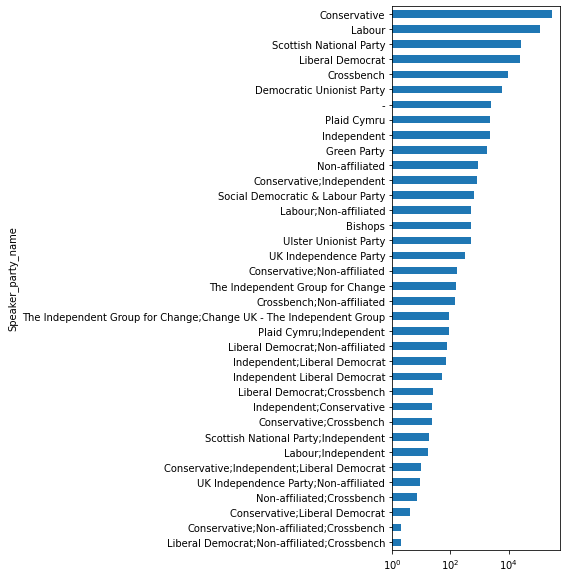

In [75]:
df.groupby("Speaker_party_name").size().sort_values(ascending=True).plot.barh(figsize=(3,10),log=True)

Next step is to create a document for each MP containing all their corresponding speaches

In [257]:
doc_pr_mp = df.groupby("Speaker_name").tokens.sum()[1:] #first element is not mp
doc_pr_mp

Speaker_name
Abbott, Diane Julie                       [secretari, state, awar, specif, relat, happen...
Abrahams, Deborah Angela Elspeth Marie    [make, power, speech, hearten, royal, colleg, ...
Adams, Nigel                              [place, record, entri, regist, member, financi...
Adonis, Andrew                            [move, take, note, case, improv, invest, plan,...
Afolami, Abimbola                         [wish, speak, briefli, graciou, speech, first,...
                                                                ...                        
Young, Barbara                            [add, last, grate, support, principl, almost, ...
Young, George                             [welcom, earli, govern, report, grate, could, ...
Younger, James                            [follow, debat, subject, secondari, ticket, re...
Zahawi, Nadhim                            [mechan, agre, unaccept, organis, set, individ...
Zeichner, Daniel Stephen                  [pleasur, follow, inspir,

Text(0, 0.5, 'Number of tokens')

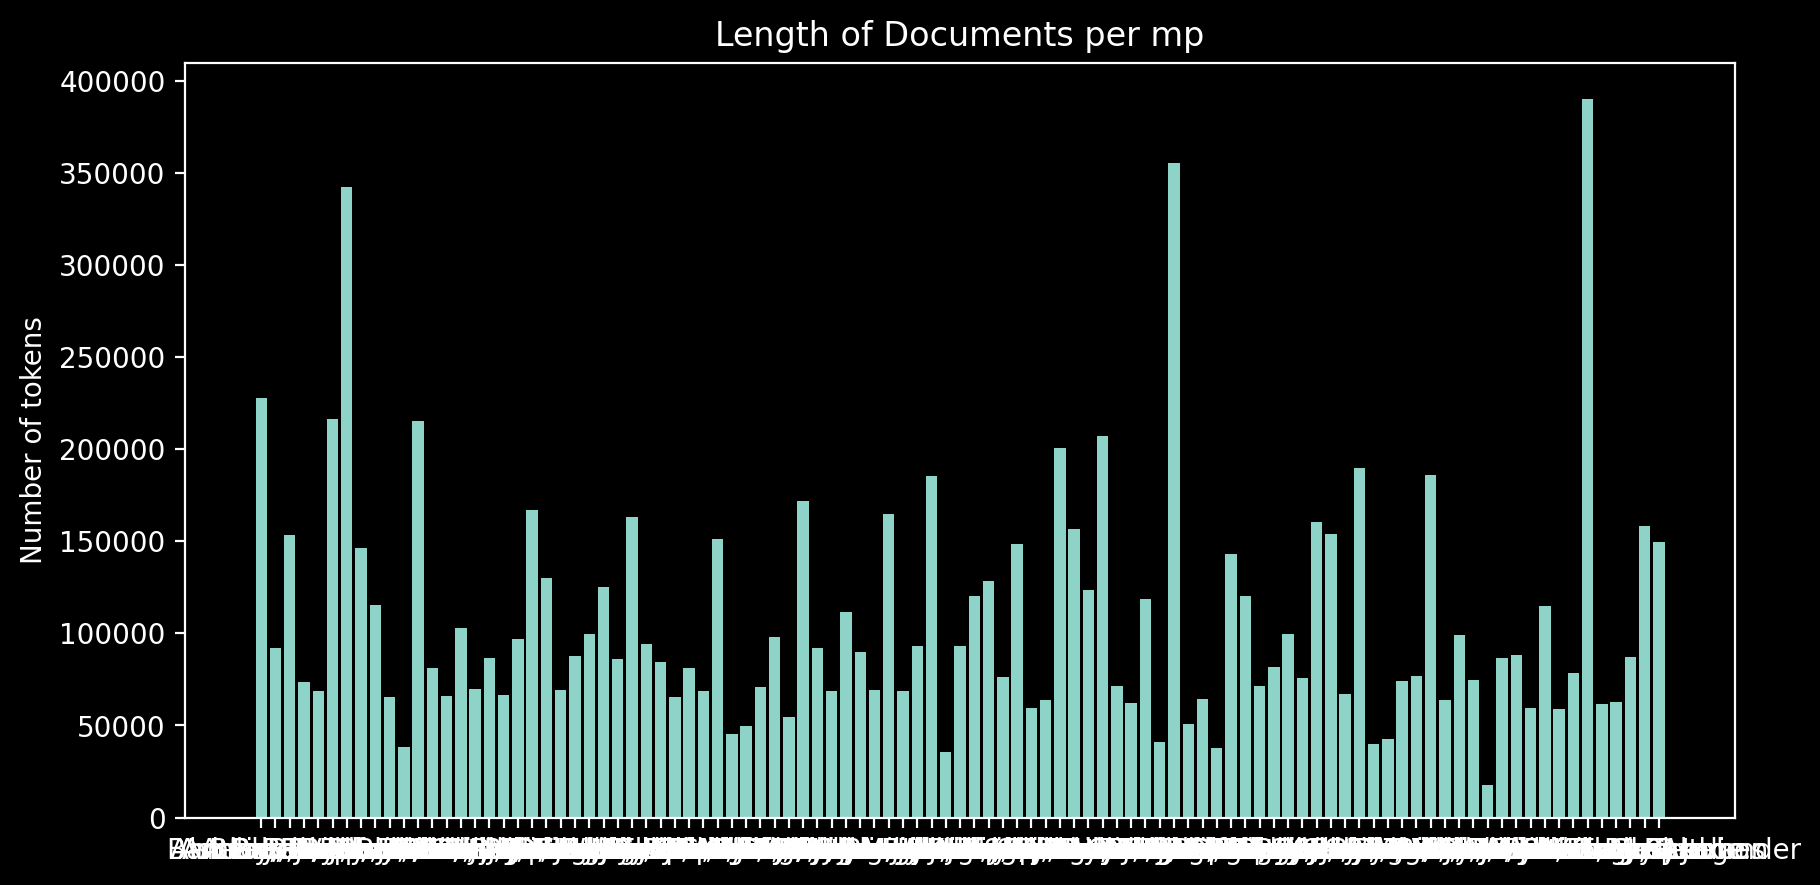

In [228]:
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(10,5), dpi=200)
ax.bar(doc_pr_mp.index, [len(x) for x in doc_pr_mp])
ax.set_title("Length of Documents per mp")
ax.set_ylabel("Number of tokens")

In [258]:
topic_list = ['education', 'health', 'brexit', 'eu',
              'business', 'immigration', 'crime',
             'care', 'world', 'foreign', 'environment',
             'economy', 'legislation', 'finance', 'employment',
             'housing', 'transport', 'tax', 'pensions', 'welfare', 'defence']

In [259]:
import networkx as nx
from networkx.algorithms import bipartite

In [349]:
G = nx.Graph()
G.add_nodes_from(doc_pr_mp.index, bipartite=0)
G.add_nodes_from(topic_list, bipartite=1)

In [261]:
stemmed_topic_list = [porter.stem(t) for t in topic_list]
freq = dict(nltk.FreqDist([x for x in doc_pr_mp.values[0] if x in stemmed_topic_list]))
freq

{'health': 193,
 'care': 85,
 'world': 47,
 'educ': 27,
 'employ': 26,
 'welfar': 6,
 'tax': 71,
 'busi': 31,
 'hous': 26,
 'financ': 7,
 'economi': 18,
 'environ': 33,
 'transport': 7,
 'crime': 304,
 'foreign': 26,
 'eu': 111,
 'immigr': 156,
 'brexit': 36,
 'legisl': 59,
 'defenc': 7,
 'pension': 19}

In [262]:
from collections import Counter
from networkx import Graph

In [263]:
counter_dict = Counter(dict())
for i in range(len(doc_pr_mp)):
    counter_dict += Counter(dict(nltk.FreqDist([x for x in doc_pr_mp.values[i] if x in stemmed_topic_list])))
avg_dict = {k: round(v/len(doc_pr_mp)) for k, v in dict(counter_dict).items()}
avg_dict

{'health': 83,
 'care': 85,
 'world': 58,
 'educ': 47,
 'employ': 37,
 'welfar': 13,
 'tax': 48,
 'busi': 94,
 'hous': 46,
 'financ': 14,
 'economi': 41,
 'environ': 18,
 'transport': 21,
 'crime': 28,
 'foreign': 23,
 'eu': 102,
 'immigr': 17,
 'brexit': 39,
 'legisl': 65,
 'defenc': 22,
 'pension': 28}

In [348]:
def get_edges(G: Graph, doc: list, mp: str, avg_dict: dict(), stemmed_topic_list):
    freq = dict(nltk.FreqDist([x for x in doc if x in stemmed_topic_list]))
    #Trying to make local avg_dict instead because some people may just hold more speeches
    for topic in freq.keys():
        if freq[topic] * 1/len(doc) >= avg_dict[topic]:
        #if freq[topic] >= np.percentile(list(freq.values()), 90):
            G.add_edge(mp, topic)

In [350]:
for i in tqdm(range(len(doc_pr_mp))):
    get_edges(G, doc_pr_mp.values[i], doc_pr_mp.index[i], avg_dict, stemmed_topic_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 898/898 [00:16<00:00, 54.45it/s]


In [351]:
print(f'The number of edges in the bipartite graph: {G.number_of_edges()}')
print(f'The number of nodes in the bipartite graph: {G.number_of_nodes()}')

The number of edges in the bipartite graph: 0
The number of nodes in the bipartite graph: 919


In [342]:
sorted(G.degree, key=lambda x: x[1], reverse=True)

[('pension', 69),
 ('welfar', 68),
 ('defenc', 68),
 ('eu', 67),
 ('foreign', 66),
 ('tax', 66),
 ('legisl', 65),
 ('financ', 65),
 ('hous', 60),
 ('brexit', 59),
 ('employ', 59),
 ('health', 57),
 ('transport', 57),
 ('care', 55),
 ('economi', 53),
 ('crime', 52),
 ('busi', 51),
 ('immigr', 50),
 ('educ', 49),
 ('environ', 45),
 ('world', 42),
 ('May, Theresa Mary', 21),
 ('Williams, Susan', 20),
 ('Leadsom, Andrea Jacqueline', 17),
 ('Bates, Michael', 16),
 ('Bercow, John Simon', 16),
 ('Shannon, Richard James', 15),
 ('Hammond, Philip', 11),
 ('Johnson, Alexander Boris de Pfeffel', 11),
 ('Neville-Rolfe, Lucy', 11),
 ('Ahmad, Tariq', 10),
 ('Cameron, David William Donald', 10),
 ('Corbyn, Jeremy Bernard', 10),
 ('Evans, Natalie', 10),
 ('Grayling, Christopher Stephen', 10),
 ('Young, George', 10),
 ('Ashton, Thomas', 9),
 ('Bilimoria, Karan', 9),
 ('Bourne, Nicholas', 9),
 ('Gardiner, John Eric', 9),
 ('Rees-Mogg, Jacob William', 9),
 ('Rosser, Richard Andrew', 9),
 ('Thewliss, Alis

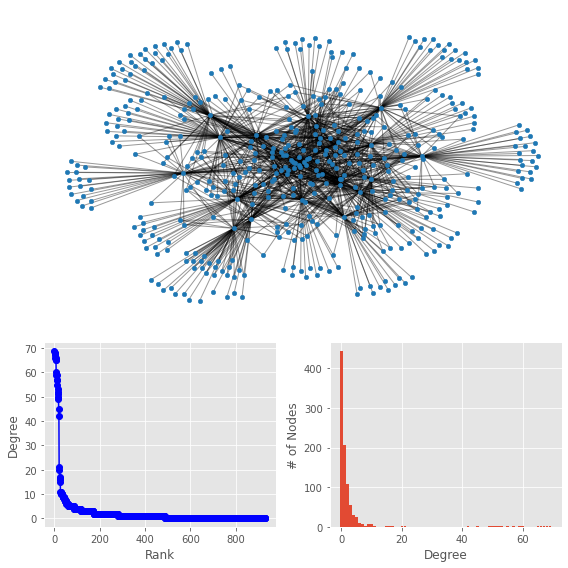

In [343]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
dmax = max(degree_sequence)
with plt.style.context('ggplot'):
    fig = plt.figure("Degree of a bipartite graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)

    ax0 = fig.add_subplot(axgrid[0:3, :])
    Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    pos = nx.spring_layout(Gcc, seed=10396953)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
    ax0.set_title("Connected components of G")
    ax0.set_axis_off()

    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")

    ax2 = fig.add_subplot(axgrid[3:, 2:])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")

    fig.tight_layout()
    plt.show()

#### Projection of the bipartite graph
Next step to get our final graph is to make a projection of our bipartite graph:

In [326]:
from networkx.algorithms import projected_graph

In [327]:
#proj_G = projected_graph(G, doc_pr_mp.index)
proj_G = bipartite.weighted_projected_graph(G, doc_pr_mp.index)
#proj_G = projected_graph(G, topic_list)

In [328]:
print(f'The number of edges in the projected graph: {proj_G.number_of_edges()}')
print(f'The number of nodes in the projected graph: {proj_G.number_of_nodes()}')

The number of edges in the projected graph: 65060
The number of nodes in the projected graph: 898


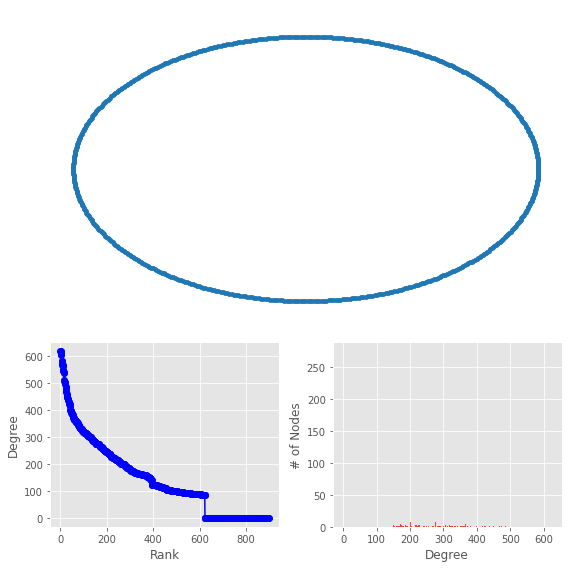

In [337]:
degree_sequence = sorted((d for n, d in proj_G.degree()), reverse=True)
dmax = max(degree_sequence)
with plt.style.context('ggplot'):
    fig = plt.figure("Degree of a bipartite graph", figsize=(8, 8))
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 4)

    ax0 = fig.add_subplot(axgrid[0:3, :])
    Gcc = G.subgraph(sorted(nx.connected_components(proj_G), key=len, reverse=True)[0])
    pos = nx.circular_layout(Gcc)
    nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
    nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
    ax0.set_title("Connected components of G")
    ax0.set_axis_off()

    ax1 = fig.add_subplot(axgrid[3:, :2])
    ax1.plot(degree_sequence, "b-", marker="o")
    ax1.set_title("Degree Rank Plot")
    ax1.set_ylabel("Degree")
    ax1.set_xlabel("Rank")

    ax2 = fig.add_subplot(axgrid[3:, 2:])
    ax2.bar(*np.unique(degree_sequence, return_counts=True))
    ax2.set_title("Degree histogram")
    ax2.set_xlabel("Degree")
    ax2.set_ylabel("# of Nodes")

    fig.tight_layout()
    plt.show()

In [242]:
import netwulf as nw

KeyboardInterrupt: 

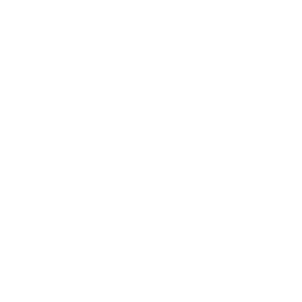

In [279]:
for k, v in proj_G.nodes(data=True):
    #May be an issue if one shifts party
    v['group'] = ParlaMint.loc[ParlaMint['Speaker_name']==k]["Speaker_party_name"].unique()[0]

for n, data in proj_G.nodes(data=True):
    data['size'] = proj_G.degree[n]
    
with plt.style.context('ggplot'):
    network, config = nw.interactive.visualize(proj_G, plot_in_cell_below=False)
    fig, ax = nw.draw_netwulf(network)

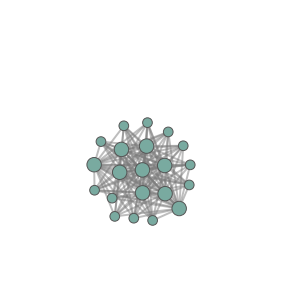

In [288]:
topic_proj_G = projected_graph(G, topic_list)
for n, data in topic_proj_G.nodes(data=True):
    data['size'] = topic_proj_G.degree[n]

with plt.style.context('ggplot'):
    network, config = nw.interactive.visualize(topic_proj_G, plot_in_cell_below=False)
    fig, ax = nw.draw_netwulf(network)